# IHLT - LABORATORY PROJECT
Done by Armando Rodriguez Ramos and Yara Yousef

## Introduction

An integral aspect of natural language processing is semantic similarity, particularly the degree of semantic similarity between texts. In this project, we explore measures of Semantic Textual Similarity (STS) between texts at the sentence level. In other words, we try to identify paraphrases according to the calculated equivalence of the sentences’ meanings.

The labels range from 0 to 5, with 0 indicating that the two sentences have no relation and 5 indicating that their meanings are identical. The complete list is as follows:

- **0:** The sentences are about different topics.
- **1:** The sentences are not equivalent, but they share the same general topic.
- **2:** The sentences are not equivalent, but they share some details.
- **3:** The sentences are roughly equivalent, but some important information is either missing from one or different.
- **4:** The sentences are mostly equivalent, though some trivial details differ.
- **5:** The sentences are completely equivalent, with the same meanings entirely.

The realization of this project follows that of a task from the SemEval 2012 workshop, from which we also get our data. The data consist of 3 training datasets: MSRvid, MSRpar and SMTeuroparl; and 5 testing datasets, of which 3 are the corresponding testing datasets for the training ones and 2 extra ones: SMTnews and OnWN, to make the task more difficult without their corresponding training sets.

This task is to implement multiple different metrics for sentence similarity, pulling from both the lexical and syntactical or semantical dimensions, and create a model combining these approaches such that we increase the overall evaluation measures. Here, this measure is mainly the Pearson correlation coefficient. However, other overall metrics, such as the Pearson correlation normalizing the output of the system for each dataset, are also used. This normalization is performed using the linear least squares method and concatenating the results for all five datasets.

The simple lexical baseline in the SemEval task description achieves a very low correlation value of only 0.311, and our goal is to improve on this by obtaining a value greater than **0.7562**.

The structure of this notebook is as follows:
1. **Setup:** Imports, reading in the data, preparing them for use, defining functions, and selecting features and similarities
2. **Data scaling:** Application of the normalizing scaler to the data
3. **Feature engineering:** Analysis to find the most important features
4. **Model training:** Create a new model for each of the five datasets and analyze the results, both individually and overall.
5. **Conclusions:** Final analysis and closing remarks

## Notebook initialization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import predefined packages

In [3]:
# General
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook

# Scorers and distances
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from nltk.metrics import jaccard_distance

# Scaler and models
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance

### Import our packages

Here, we import two of the code files external to this notebook, LexicalFeatures.py and SynSemFeatures.py. Within both of these, a third code file is called, preprocessing.py. Below, we generally describe the functions contained in these three files. The underlying concepts behind many of them will be discussed in more detail later in the notebook.


**Preprocessing.py**:

In the file, we define several different preprocessing steps, and ultimately define a final function that allows us select which preprocessing steps we want to use, such that this same function can be called for the preprocessing of all the different features, and nearly call them all in one step.

**LexicalFeatures.py**:

In the file, we define several lexical features that will be described in this notebook. The main idea of the lexical features is that they didn't need to use any WordNet information and ca be applied only using directly the words of the sentences.

**SynSemFeatures.py**:

In tis file we have defined several syntactical and semantical features which are features that use the meaning of the sentences and their word order to find relations and definition of the words to obtain good similarities results.



In [4]:
armandPath = '/content/drive/My Drive/UNIVERSITAT/Master/1-1/IHLT/LabsIHLT/Project/'
yaraPath = '/content/drive/My Drive/Labs/IHLT/Lab7/'
path = armandPath
sys.path.append(path)

In [5]:
# Created features packages
import LexicalFeatures as lexicalFT
import SynSemFeatures as synSemFT

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet_ic to /root/nltk_data...
[nltk_data]   Package wordnet_ic is already up-to-date!
[nl

### Random state for results replication

Setting the random state allows for consistency by controlling the randomness involved in machine learning models, such that the functions/models will yield the same results over different executions. We use this so we can easily tell how our changes to the model affects its performance. Otherwise, we would obtain fluctuating values, making it difficult to know whether our changes affect the performance positively or negatively, and why.

In [6]:
random_state = 42

## Read the data

The data for this project is provided by SemEval, for which an extensively annotated dataset specifically for pair-wise semantic sentence similarity was put together. They create this dataset using the following datasets as bases, and adjust them to suit our task:

1. Microsoft Research Paraphrase, or MSRPar, contains 5801 pairs of sentences taken from thousands of different internet news sources over a period of 18 months. Sampled 1500 unique pairs.

2. MSR Video Paraphrase Corpus, or MSRVid, which was cultivated by having annotates provide one-sentence descriptions of the main action or event of 2000 videos. Sampled 1500 unique pairs.

3. SMTeuroparl, specifically the human ranked French to English system submissions. Yielded 729 unique pairs.

4. Two other datasets for “out-of-domain” testing. The first contains all the human ranked French to English system submissions rom the WMT 2007 news conversation test set, and yielded 351 unique pairs. The second contains 750 pairs of glossary items from OntoNotes 4.0 and WordNet 3.1 senses.

If we check the sentences for all those datasets we will see really different behaviours and sentences types. We need to explore different preprocessing and features that will alleviate trivial differences and/or weight them appropriately.

We have two data categories: train and test. There are two aspects to the dataset files in these categories. The “input_.txt” files are the pairs, and the “gs_.txt” files are the labels, or the correct similarity values of each pair on the scale from 0 to 5.

The train set is comprised of data from three of the datasets: 50% MSRPar, 50% MSRvid, and pairs from SMTeuroparl WMT 2007.\
The test set is comprised of data from five of the datasets: 50% MSRPar, 50% MSRvid, and pairs from SMTeuroparl WMT 2008, as well as two additional “surprise” datasets.

In [7]:
trialPath_input = path+"Data/Trial/STS.input."
trainPath_input = path+"Data/Train/STS.input."
testPath_input  = path+"Data/Test/STS.input."

trialPath_gs = path+"Data/Trial/STS.gs."
trainPath_gs = path+"Data/Train/STS.gs."
testPath_gs  = path+"Data/Test/STS.gs."

In [8]:
dataset_names = ["MSRvid", "SMTeuroparl", "MSRpar", "surprise.SMTnews", "surprise.OnWN"]
only_test = ["surprise.SMTnews", "surprise.OnWN"]

dataset_trains, dataset_tests = [], []
for dataset_name in dataset_names:
  if dataset_name not in only_test:
    dataset_train = pd.read_csv(trainPath_input+dataset_name+".txt",sep='\t',header=None)
    dataset_train['gs'] = pd.read_csv(trainPath_gs+dataset_name+".txt",sep='\t',header=None)
    dataset_trains.append(dataset_train)
  
  dataset_test = pd.read_csv(testPath_input+dataset_name+".txt",sep='\t',header=None)
  dataset_test['gs'] = pd.read_csv(testPath_gs+dataset_name+".txt",sep='\t',header=None)
  dataset_tests.append(dataset_test)

## Preprocessing




Data preprocessing in machine learning is the key step to analyze and identify the inconsistencies and noise of the data. We performed the preprocessing described in the second paper of the SemEval competition, which consisted of the following steps in order:

- Strip join-symbols: "_-/\><"
- Simplify currencies: “\$US1234.56”, “\$1234.56US” → “\$1234.56”
- Tokenize the sentences
- Transform contractions: n’t  →  not, etc.
- Remove punctuation tokens:  “.” “,” etc.
- Combine compounds words as "cater" "pillar"
- POS tagging
- Remove stopwords

It is important to mention that some of the features discard this preprocessing and perform their own.

## Define features and similarities and create datasets


In this section, we define the features of the system as well as the similarity functions. All the features are being distributed into ``LexicalFeatures.py`` and ``SyntacticalFeatures.py``. The following functions help with the creation of the features and similarities dataset. We will talk about the "features dataset" when talking about the dataset with the row data of the function outputs. Some of them may directly correspond to a similarity value (due to their internal behavior and the computation of different and unique metrics); however, they may be features that return a tuple with two sets. For these features, we will compute the similarity functions and modify them by their corresponding similarity values. Like that, we will obtain what we will mention as a "similarity dataset", which is a dataset with only numerical data corresponding to all the similarities computed.

The ``createFeaturesAllDatasets`` function is capable of creating an array of datasets and applying all the functions in the parameter ``funcs`` to all the instances of the dataset. Moreover, by indicating the parameter ``features=True`` the function will create the mentioned features dataset, while "features=False`` will compute the similarities dataset. The correct usage of this function is left in the hands of the user, who will have to use a dataset with two columns of sentences for the first case and a feature dataset for the second case.

The auxiliaries ``_createFeaturesDataset`` and ``_createSimilaritiesDataset`` compute the features and similarities datasets for a single given dataset.

### Datasets creation functions 

In [9]:
# Create features of a dataset with features_funcs
def _createFeaturesDataset(datasetName, dataset, features_funcs):
  featuresValues = []
  # Traverse all the rows of the dataset computing all the features in features_funcs
  for rowSentences in tqdm_notebook(dataset.values, desc=datasetName):    
    featuresValuesAux = []
    for similatiryFunc in features_funcs.values():
      featuresValuesAux.append(similatiryFunc(rowSentences[0],rowSentences[1]))

    # Add again the target value
    featuresValuesAux.append(rowSentences[-1])
    featuresValues.append(featuresValuesAux)

  return pd.DataFrame(featuresValues, columns=[list(features_funcs.keys()) + ['target']])

# Create similarities of a dataset with similarities_funcs
def _createSimilaritiesDataset(dataset, similarities_funcs):
  newDataset = pd.DataFrame([])
  similarities_funcs[""] = lambda x: x
  # Apply each of the similarity functions to all the possible columns
  for similarityName, similatiryFunc in similarities_funcs.items():
    # All columns except from the target value
    for colName, colValues in dataset.iloc[:,:-1].items():
      # Avoid the usage of similarity functions in already computed similarities
      if (similarityName == "") ^ (type(colValues.values[0]) == tuple):
        newDataset[colName[0]+similarityName] = dataset[colName].apply(similatiryFunc)
  
  newDataset['target'] = dataset['target']
  return newDataset

# Create features or similarities for all the datasets
def createFeaturesSimilaritiesAllDatasets(datasets, funcs, features=True, train=True):
  datasetsOut = []
  computationName = 'features' if features else 'similarities'
  print(f"Computing {computationName} {('train' if train else 'test')}...")
  numRows = 0
  for idx,dataset in enumerate(datasets):
    if features:
      datasetAux = _createFeaturesDataset(dataset_names[idx], dataset, funcs)
    else:
      datasetAux = _createSimilaritiesDataset(dataset, funcs)
    datasetsOut.append(datasetAux)
    numRows += datasetAux.shape[0]
  numCols = datasetAux.shape[1]-1
  print(f"Done! Computed {numCols} {computationName} for each of the {len(datasetsOut)}"+\
        (' feature' if features==False else '')+f" datasets ({numRows*numCols} calculations in total).\n")
  return datasetsOut

### Similarities functions

We try two different similarity functions:

1) Jaccard Similarity: obtained by subtracting the Jaccard distance from 1. The distance itself is the Jaccard index subtracted from 1, where the index is the intersection of the sentences, i.e. the number of shared tokens, divided by the size of their union.

> Jaccard similarity = $ \frac{ | \ A \ \cap \ B \ | }{ | \ A \ \cup \ B \ | }  = \frac{ | \ A \ \cap \ B \ | }{| \ A \ | \ +\ | \ B \ | \ -\ | \ A \ \cap \ B \ | }$

2) Overlap Similarity: obtained by dividing the number of shared tokens by the overall length of the shorter sentence.

>Overlap similarity = $ \frac{ | \ A \ \cap \ B \ | }{ min(|X|,|Y|) } $

In [10]:
def jaccardSimilarity(sentences):
  (s0, s1) = sentences
  return 1 - jaccard_distance(s0, s1)

def overlapSimilarity(sentences):
  (s0, s1) = sentences
  intersection = s0.intersection(s1)
  return len(intersection) / min(len(s0), len(s1)) if len(intersection) != 0 else 0

### Select features and similarities to use

On this page, we select the features and similarities that we use in our best model. We will briefly explain all of them in order to know which features are used. For the similarities, we will look at both the **jaccard** and the **overlap** similarities mentioned above.

*   **Lexical**
  *   **Tokens and best tokens:**  Tokens alone imply returning the results of nltk tokenization without any other preprocessing, while "best tokens" takes the tokenization output, removes stopwords and tokens with punctuation, as well as all the described steps of the preprocessing section.
  * **Lemmas NLTK and Spacy:** Transforming the words into their lemmas using both the NLTK and the Spacy methods. The NLTK method requires first POS-tagging the tokens.
  *   **Character n-Gram overlap:** With this general feature, we have computed the overlap of **unigrams**, **bigrams** and **trigrams** for all the pairs of sentences. The function that computes the n-gram overlap metric of two sets of n-grams is: $ngo(S_{1},S_{2})=2*(\frac{|S_{1}|}{|S_{1}\cap S_{2}|}+\frac{|S_{2}|}{|S_{1}\cap S_{2}|})^{-1}$, which is equivalent to $ngo(S_{1},S_{2})=2*\frac{|S_{1}\cap S_{2}|}{|S_{1}|+|S_{2}|}$.
  *   **Vector space similarity:** We represent each sentence as a single distributional vector $U$ by summing the distributional vector of each word in the sentence. For a pair of sentences, we create an ordered array, called $W$, containing all the unique words for both sentences. Then, we create a vector for each of the two sentences of length $W$. The number in the ith position of the vector of sentence $S$ represents the number of times the ith word of $W$ appears in that sentence. Finally, we compute the absolute cosine between the two sentences for which we would like to compute the similarity.
*   **Syntactical / Semantical:**
  *   **Average lexical semantics:** Obtaining similarities using four different WordNet functions:
      * Path returns a score based on the shortest path that connects the senses in the hypernym/hyponym taxonomy.
      * Leacock-Chodorow returns a score based on both the shortest path that connects the senses and the maximum depth of the taxonomy in which the senses can occur.
      * Wu-Palmer returns a score based on the depth of the two senses in the taxonomy and that of their Least Common Subsumer (the closest shared relational concept).
      * Lin returns a score based on the Information Content of the Least Common Subsumer along with that of the two synsets.
  *   **Word Sense Disambiguation (Lesk):**  This feature uses the Lesk algorithm for word sense disambiguation, which is based on the assumption that the words in the sentence are being used to discuss the same subject. An external text describing the sense of the word in question, such as its dictionary definition, is compared to the other words of the sentence to see if that meaning of the word matches the meaning of the sentence. The potential sense with the highest number of shared words is taken as the most likely intended meaning. The Lesk algorithm is used to generate the main synsets of the words of the sentences, considering that only the ones that are nouns, verbs, adjectives, or adverbs will be able to be evaluated. The rest of words will be discarted if they were stopwords and added lowered instead.
  *   **Name entities:** Identifying and combining “name entities” such as the first and last name(s) of a person or the name of a corporation.
  *   **WordNet-augmented word overlap:** It is a word overlap metric that uses WordNet to assign partial scores to words that are not common to both sentences. The score for one sentence versus the other is computed with the sums of the scores of each word. The score of each word is computed as the maximum path similarity among all the words in the second sentence.
  *   **Weighted word overlap:** When measuring sentence similarities, we give more importance to words bearing more content by using the information content; hence, we measure the sentence similarities using the harmonic mean of $wwc(S_{1},S_{2})=\frac{\sum_{w\in S_{1}\cap S_{2}}ic(w)}{\sum_{w'\in S_{2}}ic(w')}$ where the $ic(w)$ represents the information content of the word $w$ using the *Brown Corpus*.
  *   **Weighted Vector Space similarity:** Lastly, this feature is really similar to vector space similarity of the lexical part but differs in the fact that the number in the ith position is multiplied, or weighted, by the information content of this word in the *Brown Corpus*.

In [11]:
features_funcs = {
  # Lexical
  'tokens': lexicalFT.tokenizeSentences,
  'bestTokens': lexicalFT.tokenizeSentencesBestTokens,
  'lemmasNltk': lexicalFT.lemmasNltk,
  'lemmasSpacy': lexicalFT.lemmasSpacy,
  "unigramOverlap": lambda s0,s1: lexicalFT.nGramsOverlap(s0,s1,1),
  "bigramOverlap": lambda s0,s1: lexicalFT.nGramsOverlap(s0,s1,2),
  "trigramOverlap": lambda s0,s1: lexicalFT.nGramsOverlap(s0,s1,3),
  "vectorSpace": lambda s0,s1: synSemFT.computeVectorSpace(s0,s1,ic=False), # It is on the synSemFeatures to avoid the function repetition
  # Syntactical / Semantical
  'lexicalSemanticsPa': lambda s0,s1: synSemFT.lexicalSemantics(s0,s1,sim="pa"),
  'lexicalSemanticsLc': lambda s0,s1: synSemFT.lexicalSemantics(s0,s1,sim="lc"),
  'lexicalSemanticsWu': lambda s0,s1: synSemFT.lexicalSemantics(s0,s1,sim="wu"),
  'lexicalSemanticsLi': lambda s0,s1: synSemFT.lexicalSemantics(s0,s1,sim="li"),
  'lesk': synSemFT.lesk,
  'nameEntities': synSemFT.nameEntitiesSpacy,
  "augmentedWordOverlap": synSemFT.computeWNAOverlap,
  "weightedWordOverlap": synSemFT.computeWWOverlap,
  "weightedVectorSpace": lambda s0,s1: synSemFT.computeVectorSpace(s0,s1,ic=True),
}
similarities_funcs = {
  "Jaccard": jaccardSimilarity,
  "Overlap": overlapSimilarity
}

### Create features and similarities datasets

Here, we use the previously defined function createFeaturesSimilaritiesAllDatasets() to iterate through all the datasets and get both the features and the similarity values for all the pairs contained within them. This is the first step in preparing the data for the model to train on.

In [12]:
%%time
# Features datasets
trainDatasetsFeatures = createFeaturesSimilaritiesAllDatasets(dataset_trains, features_funcs, features=True, train=True)
testDatasetsFeatures  = createFeaturesSimilaritiesAllDatasets(dataset_tests, features_funcs, features=True, train=False)

# Similarities datasets
trainDatasetsSimilarities = createFeaturesSimilaritiesAllDatasets(trainDatasetsFeatures, similarities_funcs, features=False, train=True)
testDatasetsSimilarities  = createFeaturesSimilaritiesAllDatasets(testDatasetsFeatures, similarities_funcs, features=False, train=False)

Computing features train...


MSRvid:   0%|          | 0/750 [00:00<?, ?it/s]

SMTeuroparl:   0%|          | 0/734 [00:00<?, ?it/s]

MSRpar:   0%|          | 0/750 [00:00<?, ?it/s]

Done! Computed 17 features for each of the 3 datasets (37978 calculations in total).

Computing features test...


MSRvid:   0%|          | 0/750 [00:00<?, ?it/s]

SMTeuroparl:   0%|          | 0/459 [00:00<?, ?it/s]

MSRpar:   0%|          | 0/750 [00:00<?, ?it/s]

surprise.SMTnews:   0%|          | 0/399 [00:00<?, ?it/s]

surprise.OnWN:   0%|          | 0/750 [00:00<?, ?it/s]

Done! Computed 17 features for each of the 5 datasets (52836 calculations in total).

Computing similarities train...
Done! Computed 23 similarities for each of the 3 feature datasets (51382 calculations in total).

Computing similarities test...
Done! Computed 23 similarities for each of the 5 feature datasets (71484 calculations in total).

CPU times: user 6min 31s, sys: 6.79 s, total: 6min 38s
Wall time: 6min 46s


## Scale the data

In this small chunk of code, we scale all the datasets. We used the MinMaxScaler, which is a normalization scaler that transforms features by scaling each of them to a given range, which was decided to be between 0 and 1. This transformation is performed individually such that it is in the given range on the training set. We fitted a different scaler with the training data for each of the datasets. For the only testing datasets (SMTnews and OnWN), we fitted a scaler with the combination of the three training datasets and transformed the test data with it. It is also really important to mention that we don't scale the target value as long as we have seen that using the range 0 to 5 works perfectly. Also, note that we don't have to discard the non-scaled datasets because the models for the different datasets may or may not prefer to use this scaled data or the original one.

In [13]:
trainDatasetsSimilaritiesScaled = []
testDatasetsSimilaritiesScaled = []

for idx in range(len(testDatasetsSimilarities)):
  dataset_test = testDatasetsSimilarities[idx]
  if idx > 2: dataset_train = pd.concat(trainDatasetsSimilarities)
  else: dataset_train = trainDatasetsSimilarities[idx]

  # Get the train and test data
  X_train = dataset_train.loc[:, dataset_train.columns != 'target'].values
  y_train = dataset_train['target'].values.ravel()
  X_test = dataset_test.loc[:, dataset_test.columns != 'target'].values
  y_test = dataset_test['target'].values.ravel()

  # Use the scaler to transform the test data
  scaler = MinMaxScaler().fit(X_train)
  if idx <= 2:
    trainDf = pd.DataFrame(scaler.transform(X_train), columns=dataset_train.columns.values[:-1])
    trainDf['target'] = y_train
    trainDatasetsSimilaritiesScaled.append(trainDf)
  
  testDf = pd.DataFrame(scaler.transform(X_test), columns=dataset_test.columns.values[:-1])
  testDf['target'] = y_test
  testDatasetsSimilaritiesScaled.append(testDf)

## Feature engineering

In this section, we run an analysis on the features of test sets in order to identify which of those features are the most and least important. The importance of each feature is calculated using the mean of the results of sklearn’s presumutation_importance() function. We will then be able to use these results to select the most important of these features to inform the creation of our chosen model.

### Feature importance

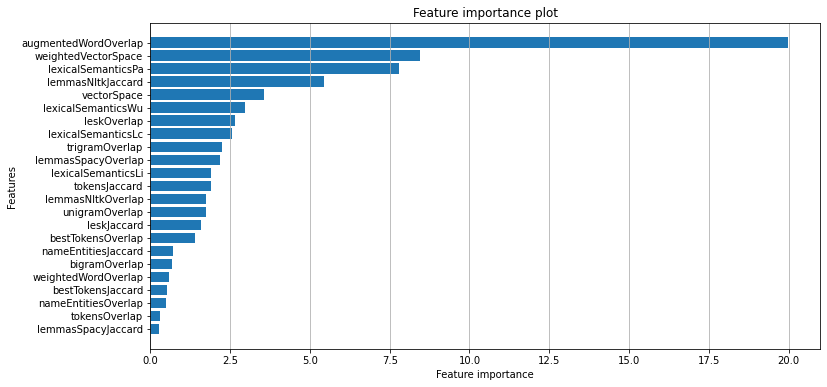

In [14]:
# Obtain the train data
trainDataset = pd.concat(trainDatasetsSimilaritiesScaled)
X_train = trainDataset.loc[:, trainDataset.columns != 'target'].values
y_train = trainDataset['target'].values.ravel()

# Create and fit the model to be analysed
model = MLPRegressor(max_iter=1000, random_state=random_state).fit(X_train, y_train)

# Obtain the test data
testDataset = pd.concat(testDatasetsSimilaritiesScaled)
X_test = testDataset.loc[:, trainDataset.columns != 'target'].values
y_test = testDataset['target'].values.ravel()

# Compute the permutaiton importance algorithm
pearson_scorer = make_scorer(lambda x, y: pearsonr(x, y)[0])
r_multi = permutation_importance(model, X_test, y_test, n_repeats=100, random_state=random_state, scoring=pearson_scorer)

# Plot feature importance
feature_importance = r_multi.importances_mean*100
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(testDataset.columns)[sorted_idx])
plt.grid(axis='x'); plt.title('Feature importance plot')
plt.xlabel("Feature importance"); plt.ylabel("Features")
plt.show()

This plot represents the feature importance for the best obtained model, which incorporated all lexical and syntactical features.We can see that we have a clear winner: the WordNet-augmented word overlap, which drastically overcomes all the other features. The importance of this feature could be due to the fact that it is between the lexical and semantical dimensions. We can say that because it is basically a word overlap, which computes the overlapping using the maximum path similarity within the words of the sentence.


Moreover, we can see that there are also interesting features, such as the vector space, which obtains a good classification by itself and with the use of the weighted version. Moreover, the lexical semantics using path similarity and the simple lemmatization of the nltk also obtain really good results. At this point, the importance of the features starts to decrease a lot, achieving the spacy lemmatization at the end. This kind of surprises us because we think that the lemmatization worked really well, but the model seems to think the contrary. As long as the model is a Multi-Layer Perceptron, the feature importance is computed with the ``permutation_importance`` function, which does a lot of tests to select the plot we are describing.

## Models training and results

In this part of the code, we train the five models (one for each dataset) using the three training datasets and the combination of those three into a concatenated one for the last two models.

For each of the models, we tested different Sklearn models. We produced a grid search of parameters for all the following models:
- SVR
- AdaBoostRegressor with DecisionTreeRegressor
- RandomForestRegressor
- LGBMRegressor
- MLPRegressor

Doing that, we found that the MLPRegressor (Multi-layer Perceptron Regressor) and the LGMRegressor (Light-Gradient Boosting Machine Regressor) were the ones that achieved the best results. Moreover, to increase the search space of models we have decided to test which combination of scaling the data resulted in the best results. As a result, we test all of these model and scale combinations: using gradient boost or multi-layer perceptrons, and scaling or not scaling the data.The differences in training and instantiation times were negligible. So, we have discovered that the MLPRegressor was the one that better adapted to the data of all the datasets, obtaining the higher Pearson correlation values. However, some of the datasets obtained better results without the data scaling, so we are not applying the MinMaxScaler to the first two datasets.

Moreover, the best parameters found in each of the datasets rely on really similar values that also resemble the default initialization of the net. Hence, in order to simplify the code and not modify the base model for each of the datasets, we used the MLPRegressor with the default parameters. The only important parameter that we have to set is the maximum number of iterations, which was set to 1000 to allow the neural network to fit the data until convergence. This number of iterations only sets their limit, but the MLPRegressor will stop sooner if the convergence point has already been reached.

Lastly, we will briefly mention that at the start we used a general model for all the datasets, but then we found that specific models can be used for each of the datasets separately, which resulted in an incredible improvement in the results of the Pearson correlation.

In [15]:
%%time
y_test_true = []
y_test_preds_all = []
y_test_preds_norm = []
y_test_preds_mean = 0

scale = (False, False,  True,  True,  True)

for idx in range(len(testDatasetsSimilarities)):
  if idx > 2: print(dataset_names[idx].split(".")[1])
  else: print(dataset_names[idx])

  # Get the train and test data and scale if wanted
  if scale[idx]:
    dataset_test = testDatasetsSimilaritiesScaled[idx]
    if idx > 2: dataset_train = pd.concat(trainDatasetsSimilaritiesScaled)
    else: dataset_train = trainDatasetsSimilaritiesScaled[idx]
  else:
    dataset_test = testDatasetsSimilarities[idx]
    if idx > 2: dataset_train = pd.concat(trainDatasetsSimilarities)
    else: dataset_train = trainDatasetsSimilarities[idx]
  
  X_train = dataset_train.loc[:, dataset_train.columns != 'target'].values
  y_train = dataset_train['target'].values.ravel()
  X_test = dataset_test.loc[:, dataset_test.columns != 'target'].values
  y_test = dataset_test['target'].values.ravel()

  model = MLPRegressor(max_iter=1000, random_state=random_state).fit(X_train, y_train)

  y_train_pred = model.predict(X_train)
  y_test_pred = model.predict(X_test)

  # All
  y_test_true = y_test_true + list(y_test)
  y_test_preds_all = y_test_preds_all + list(y_test_pred)
  all_pearson = pearsonr(y_test, y_test_pred)[0]

  # Norm
  model = LinearRegression().fit(np.array(y_test_pred).reshape(-1, 1), np.array(y_test).reshape(-1, 1))
  y_test_pred_norm = model.predict(np.array(y_test_pred).reshape(-1,1)).squeeze()
  y_test_preds_norm = y_test_preds_norm + list(y_test_pred_norm)

  # Mean
  y_test_preds_mean += all_pearson*len(y_test)

  # Show results
  print(" Train:")
  print("  Score:", round(r2_score(y_train, y_train_pred),4))
  print("  Pearson:", round(pearsonr(y_train, y_train_pred)[0],4))

  print(" Test:")
  print("  Score:", round(r2_score(y_test, y_test_pred),4))
  print("  Pearson:", round(all_pearson,4))
  print()

MSRvid
 Train:
  Score: 0.7612
  Pearson: 0.8731
 Test:
  Score: 0.7475
  Pearson: 0.8662

SMTeuroparl
 Train:
  Score: 0.5295
  Pearson: 0.7279
 Test:
  Score: -0.0607
  Pearson: 0.4856

MSRpar
 Train:
  Score: 0.518
  Pearson: 0.7203
 Test:
  Score: 0.4076
  Pearson: 0.6439

SMTnews
 Train:
  Score: 0.7762
  Pearson: 0.8821
 Test:
  Score: -0.3299
  Pearson: 0.4075

OnWN
 Train:
  Score: 0.7762
  Pearson: 0.8821
 Test:
  Score: 0.1637
  Pearson: 0.6677

CPU times: user 12.1 s, sys: 9.82 s, total: 22 s
Wall time: 11.4 s


We evaluate the model’s performance on the combined data using both the pearson correlation coefficient and the R-squared regression score. While the latter does not yield a particularly high score, we find that our pearson correlation is 0.8214, well above the desired 0.7562. Moreover we have also computed the normalized Pearson correlation and the average Pearson correlation for each of the datasets. 

We discuss these results further in the conclusions section.

In [16]:
print("Global test results using multi models:")
print("  Score:", round(r2_score(y_test_true, y_test_preds_all),4))
print("  Pearson ALL:", round(pearsonr(y_test_true, y_test_preds_all)[0],4))
print("  Pearson NORM:", round(pearsonr(y_test_true, y_test_preds_norm)[0],4))
print("  Pearson MEAN:", round(y_test_preds_mean/len(y_test_true),4))
print()

Global test results using multi models:
  Score: 0.6537
  Pearson ALL: 0.8214
  Pearson NORM: 0.8496
  Pearson MEAN: 0.6495



## Conclusions

In this section, we will first summarize a bit of the work done, then analyze the results, and finally compare them with the ones in the papers.



### Summary of the steps

To approach the task of creating a model to predict the Semantic Textual Similarity of two sentences, we took the following steps:

1. In three external code files, we create a structure for flexible preprocessing such that we can choose which steps are applied, and implement these in the definitions of the lexical and syntactic/semantic feature functions.

2. We read in the data from the train and test folders.

3. We define functions that facilitate the creation of the features or the obtainment of the similarities for datasets.

4. We define our similarity functions, Jaccard and Overlap.

5. We select which features and similarities to use for our best model.

6. We create the features and similarities datasets accordingly.

7. We scale the data using the MinMax normalization scaler, excepting the two first models which worked better without the scaling.

8. We perform feature engineering by analyzing the train and testing the set features to determine which are the most important and whether any can be safely dropped. However, none of the features expected to be deleted helped the performance of the model.
    - We find that in the lexical dimension, none of the features are individually significantly more or less important.
    - In the syntactic/semantic dimension, augmentedWorldOverlap is much more important than any of the other features.
    - Overall, the three most important features were found to be augmentedWorldOverlap, weightedVectorSpace, and lexicalSemanticsPa. We note that augmentedWorldOverlap is by far the most important of all the combined features.

9. We tested different models and found that MLPRegressor both achieved the best results and adapted best to the data of the different datasets.

10. Finally, we train and obtain our results which are the ones on the following table.

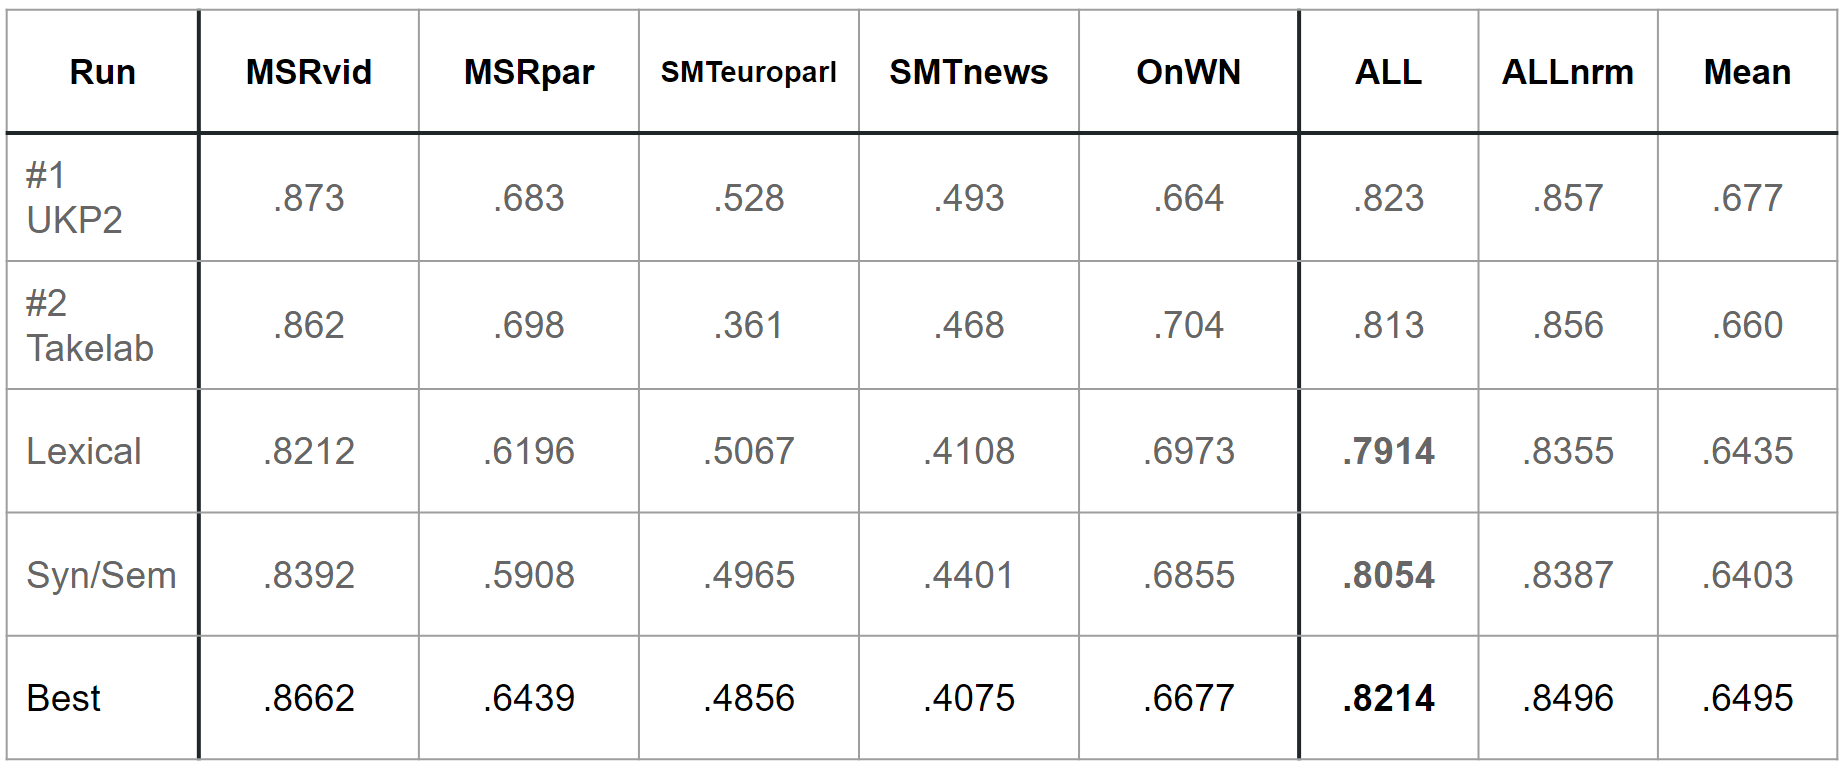

### Analysis of the results

Looking at our best model, we discover that MSRvid is by far the best dataset for testing the model. Then, MSRPar and OnWN are on a second level, about 0.2 lower, and SMTeuroparl and SMTnews are on a third level, another 0.2 lower.


Overall, we do not see a really significant difference between the correlation values of the datasets using only lexical or syntactic/semantic features. However, MSRpar has a much better Pearson correlation (0.6234) when using only the lexical features than the value when using the syntactical and semantic (Syn/Sem) ones, which is only 0.5865. Furthermore, we can see an inverse case in which the Syn/Sem dimension outperforms the lexical dimension by a similar margin of around 0.04. As a result, we could say that the MSRpar is simpler, works better, or is more precise in the lexical dimension, whereas the SMTnews is more decanted to the syntactical or semantical dimension. The other three datasets seem to be comfortable with both dimensions.


While it may not be immediately evident that combining the lexical and syntactic/semantic dimensions has a positive effect on model performance when looking at the datasets individually (as long as only the MSRvid and MSRpar improve individual performance), we can see it in the "ALL" column, for which all the datasets are combined. Here, we get an overall value of ~0.787 for the lexical dimension and ~0.808 for the syntactic/semantic dimension, and, when the two are combined, we achieve a value of ~0.821.


As such, we conclude that the combination of the features from these different dimensions is beneficial for finding the best possible Semantic Textual Similarity. As a final recall, we will also mention that the WordNet-Augmented word overlap obtained a Pearson correlation of 0.7561 on its own, clearly indicating its importance in the created models.

### Comparison with the papers


The first two rows are the Pearson correlation results obtained by the UKP2 and TakeLab papers, which we will use as a check for the quality of our own "Best" results.


MSRvid: We obtain ~0.866, which is slightly lower than UKP2 and slightly higher than TakeLab.


MSRpar: we obtain ~0.644, a value a bit lower than both of those teams’.


SMTeuroparl: We obtain 0.486, which is a bit lower than UKP2 but quite a bit higher than TakeLab.


SMTnews: We obtain ~0.412, which is somewhat lower than both of those teams’.


OnWN: We obtain ~0.668, which is slightly higher than UKP2 and lower than TakeLab.


Overall (all datasets together): Our value, ~**0.821**, is practically the same but a bit lower than the UKP2 and slightly higher than that of TakeLab. The normalized and mean correlation values are also similar, though slightly lower.

### Final conclusions

As a result, we provided a solution for the STS project that works really well and raises the score of the second participant. Five separate trained Multi-Layer Perceptron models were utilized to build the proposal's framework, and the results produced a final correlation score of **0.8214** across a variety of lexical, syntactic, and semantic similarity measures.